# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Adtividad Semana 5

### **Vectores Embebidos de OpenAI**

#### **Nombres y matrículas de los integrantes del equipo:**



*   Scarlet Marie Wessin Romero A01796242
*   Emmanuel Merida Toledo A01795858
*   Carlos Pano Hernández A01066264
*   Mireya Isabel Pérez Del Razo A01795608


In [9]:
# !pip install numpy==1.23.5
# !pip install gensim==4.3.1

In [10]:
# !python3 -m spacy download en_core_web_lg

In [11]:
# !pip install fasttext

In [12]:
# Aquí deberás incluir todas las librerías que requieras durante esta actividad:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import re
import string
import zipfile
import os
from openai import OpenAI
import gensim
import spacy
import en_core_web_lg
from scipy.spatial import distance
import fasttext
import fasttext.util

ModuleNotFoundError: No module named 'google.colab'

In [3]:
# Incluye las celdas necesarias para tu acceso a la API de OpenAI.

client = OpenAI(
  api_key=userdata.get("key")
)

completion = client.chat.completions.create(
  model="gpt-4o-mini",
  store=True,
  messages=[
    {"role": "user", "content": "write a short 10 words definition of love"}
  ]
)

print(completion.choices[0].message);

ChatCompletionMessage(content='A profound emotional connection characterized by affection, care, and commitment.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None)


# **Pregunta - 1:**



Descarga los 3 archivos de Canvas y genera un nuevo DataFrame de Pandas con ellos.

**Llama simplemente "df" a dicho DataFrame.**

Los archivos los encuentras en Canvas: amazon5.txt, imdb5.txt, yelp5.txt.



In [4]:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********
amazon_df = pd.read_csv('Data/amazon5.txt', sep='\t', header=None, names=['text', 'label'])
imdb_df = pd.read_csv('Data/imdb5.txt', sep='\t', header=None, names=['text', 'label']) 
yelp_df = pd.read_csv('Data/yelp5.txt', sep='\t', header=None, names=['text', 'label'])

# Add source column to identify which dataset each review came from
amazon_df['source'] = 'amazon'
imdb_df['source'] = 'imdb'
yelp_df['source'] = 'yelp'

# Concatenate
df = pd.concat([amazon_df, imdb_df, yelp_df], ignore_index=True)

# *********** Aquí termina la sección de agregar código *************


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Verifiquemos la información del DataFrame:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3000 non-null   object
dtypes: object(1)
memory usage: 23.6+ KB


In [6]:
# Y veamos sus primeros registros:
df.head()

,text
0,So there is no way for me to plug it in here i...
1,"Good case, Excellent value.\t1"
2,Great for the jawbone.\t1
3,Tied to charger for conversations lasting more...
4,The mic is great.\t1


# **Pregunta - 2:**

Realiza el proceso de limpieza. Aplica el preprocesamiento que consideres adecuado.











In [7]:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

# Limpiamos el texto reemplazando los tabuladores por espacios y separamos la etiqueta del comentario.
# Como los datos de IMDB no usan tabulador para separar la etiqueta, usamos rsplit para dividir desde el final.
# Esto permite extraer correctamente la etiqueta (Y) como la última palabra del texto.
df['text'] = df['text'].str.replace('\t', ' ', regex=False)
df[['text', 'Y']] = df['text'].str.rsplit(n=1, expand=True)
df['Y'] = df['Y'].astype(int)
Y = df['Y'].copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3000 non-null   object
 1   Y       3000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 47.0+ KB


In [8]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 200)

In [9]:
# visualizando los comentarios para evaluar que procesos de limpieza son pertinentes
print("=== First 10 comments ===")
for i, text in enumerate(df['text'].head(10), start=1):
    print(f"{i}. {text}\n")

=== First 10 comments ===
1. So there is no way for me to plug it in here in the US unless I go by a converter.

2. Good case, Excellent value.

3. Great for the jawbone.

4. Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!

5. The mic is great.

6. I have to jiggle the plug to get it to line up right to get decent volume.

7. If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.

8. If you are Razr owner...you must have this!

9. Needless to say, I wasted my money.

10. What a waste of money and time!.



In [10]:
# visualizando los comentarios para evaluar que procesos de limpieza son pertinentes
print("=== Random sample of 10 comments ===")
for i, text in enumerate(df['text'].sample(10), start=1):
    print(f"{i}. {text}\n")

=== Random sample of 10 comments ===
1. It was forced, like everything in this movie.

2. They really want to make your experience a good one.

3. I bought this battery with a coupon from Amazon and I'm very happy with my purchase.

4. Good show, Samsung.

5. Everything about this product is wrong.First

6. I could care less... The interior is just beautiful.

7. It works fine on my Motorola 325 cellphone, and a lot better than the worn-out battery did.

8. But the premise of the film was so ridiculous: that the President of the U.S.

9. SWEETEST PHONE!!!

10. A great film by a great director.



In [11]:
# Descargar el tokenizador y las stopwords
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# limpieza

# Modelo spaCy
nlp = spacy.load("en_core_web_sm")

# Stopwords de NLTK
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Pasar a minúsculas
    text = text.lower()

    # Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Eliminar cualquier carácter que no sea letra o espacio
    text = re.sub(r'[^a-z\s]', '', text)

    # Colapsar múltiples espacios en uno solo
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenizar
    tokens = word_tokenize(text)

    # Quitar stopwords
    tokens = [tok for tok in tokens if tok not in stop_words]

    # Lematizar con spaCy
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_ for token in doc]

    # Reconstruir el texto limpio
    return " ".join(lemmas)

# Crear Xclean
Xclean = df['text'].apply(clean_text)

# *********** Aquí termina la sección de agregar código *************

In [13]:
# Despleguemos los primeros comentarios después de tu proceso de limpieza:
for x in Xclean[0:5]:
  print(x)

way plug we unless go converter
good case excellent value
great jawbone
tie charger conversation last minutesmajor problem
mic great


# **Pregunta - 3:**



Realicemos una partición aleatoria con los mismos porcentajes de la práctica pasada para poder comparar dichos resultados con los de
esta actividad, a saber, 70%, 15% y 15%, para entrenamiento, validación y prueba, respectivamente.

In [ ]:

# ************* Inicia la sección de agregar código:*****************************

from sklearn.model_selection import train_test_split

x_train, x_val_and_test, y_train, y_val_and_test = train_test_split(Xclean, Y, train_size=.70, shuffle=True, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_and_test, y_val_and_test, test_size=.50, shuffle=True, random_state=17)


# *********** Termina la sección de agregar código *************


# verificemos las dimensiones obtenidas:
print('X,y Train:', len(x_train), len(y_train))
print('X,y Val:', len(x_val), len(y_val))
print('X,y Test', len(x_test), len(y_test))

NameError: name 'Xclean' is not defined

In [7]:
print(x_train)

NameError: name 'x_train' is not defined

# **Pregunta - 4:**



Construye tu vocabulario a continuación


In [15]:
# a.	Usa el conjunto de entrenamiento para generar tu vocabulario
#     con un tamaño que consideres adecuado:


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********
from collections import Counter
import pandas as pd
from typing import List, Tuple

# funcion para tokenizar, contar frecuencias y longitudes de tokens en una Serie de textos. Devuelve un DataFrame con columnas ['token','count','length'].
def compute_token_stats(texts: pd.Series) -> pd.DataFrame:
    token_counts = Counter()
    for tokens in texts.str.split():
        token_counts.update(tokens)
    df = pd.DataFrame(token_counts.items(), columns=['token','count'])
    df['length'] = df['token'].str.len()
    return df.sort_values('count', ascending=False).reset_index(drop=True)

# dada la distribución de frecuencias en df['count'], devuelve cuántos tokens cubren al menos `coverage` de las apariciones.
def determine_vocab_size(df: pd.DataFrame, coverage: float = 0.90) -> int:
    df = df.copy()
    df['cum_freq'] = df['count'].cumsum() / df['count'].sum()
    return int((df['cum_freq'] <= coverage).sum())

# filtrar tokens con count>=min_freq y length>=min_len, luego toma los max_vocab más frecuentes.
def build_vocab(token_stats: pd.DataFrame,
                min_freq: int,
                min_len: int,
                max_vocab: int) -> List[str]:

    filtered = token_stats[
        (token_stats['count'] >= min_freq) &
        (token_stats['length'] >= min_len)
    ]
    return filtered['token'].tolist()[:max_vocab]

# estadisticas sobre el conjunto de entrenamiento
token_stats = compute_token_stats(x_train)

print("=== Estadísticas de frecuencia ===")
print(token_stats['count'].describe(), "\n")
print("=== Estadísticas de longitud ===")
print(token_stats['length'].describe(), "\n")

# tamaño de vocabulario para 90% de cobertura
vocab_size_90 = determine_vocab_size(token_stats, coverage=0.90)
print(f"Términos necesarios para cubrir el 90 %: {vocab_size_90}")

# definir los umbrales
min_freq = 3
min_len  = 3

# construir vocabulario final
vocab = build_vocab(token_stats, min_freq, min_len, vocab_size_90)

=== Estadísticas de frecuencia ===
count    3492.000000
mean        3.771764
std        10.481273
min         1.000000
25%         1.000000
50%         1.000000
75%         3.000000
max       212.000000
Name: count, dtype: float64 

=== Estadísticas de longitud ===
count    3492.000000
mean        6.593356
std         2.599527
min         1.000000
25%         5.000000
50%         6.000000
75%         8.000000
max        33.000000
Name: length, dtype: float64 

Términos necesarios para cubrir el 90 %: 2174


In [16]:
# b.	Indica el tamaño del vocabulario generado.

# ******* Inicia la sección de agregar código: ***********

print(f"Longitud del vocabulario generado: {len(vocab)}")
print("Primeros 20 términos del vocabulario:", vocab[:20])

# *********** Aquí termina la sección de agregar código *************

Longitud del vocabulario generado: 884
Primeros 20 términos del vocabulario: ['not', 'good', 'great', 'movie', 'phone', 'film', 'work', 'bad', 'well', 'like', 'time', 'one', 'place', 'service', 'food', 'get', 'make', 'really', 'use', 'would']


c.	¿Por qué debe usarse solamente el conjunto de entrenamiento para generar el vocabulario?


### ++++++++ Inicia la sección de agregar texto: +++++++++++

Para evitar fugas de información (data leakage), el vocabulario debe construirse únicamente a partir del conjunto de entrenamiento. El vocabulario determina qué palabras el modelo conoce y puede procesar.

Si se genera utilizando todo el conjunto de datos (entrenamiento + prueba), el modelo estaría expuesto a ejemplos que, en teoría, aún no ha visto. Esto implica que podría aprender patrones o palabras presentes en el conjunto de prueba, lo cual sesga el aprendizaje y compromete la objetividad de la evaluación.

Como consecuencia, las métricas de rendimiento (como precisión, recall, y F1) podrían estar artificialmente infladas, ya que el modelo estaría “prediciendo” sobre datos que, en realidad, ya conoce parcialmente.

### ++++++++ Termina la sección de agregar texto: +++++++++++


In [17]:
# d.	Con el vocabulario generado, filtra los conjuntos de entrenamiento,
#     validación y prueba para que todos los comentarios usen solamente las
#     palabras de este vocabulario.

#     Llamar train_x, val_x y test_x a estos tres conjuntos.


# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

def filter_by_vocab(text_series: pd.Series, vocab: List[str]) -> pd.Series:
    vocab_set = set(vocab)
    return text_series.apply(
        lambda txt: " ".join(tok for tok in txt.split() if tok in vocab_set)
    )

# Aplicar el filtrado a cada partición
train_x = filter_by_vocab(x_train, vocab)
val_x   = filter_by_vocab(x_val,   vocab)
test_x  = filter_by_vocab(x_test,  vocab)


# *********** Aquí termina la sección de agregar código *************


In [18]:
# Vemos el resultado de los primeros comentarios del conjunto de entrenamiento:

for ss in train_x[0:5]:
  print(ss)

not much well people like waste
suck
pay bill tip feel server terrible job
call can not cook steak not understand
however keypad tinny sometimes wrong button


# **Pregunta - 5:**


#### **Incluye aquí un resumen de las características y diferencias que tiene al menos los tres modelos de OpenAI indicados: "text-embedding-3-small", "text-embedding-3-large" y "text-embedding-ada-002".**

### ++++++++ Inicia la sección de agregar texto: +++++++++++

**text-embedding-3-small**
- 1,536 dimensiones por defecto (configurable hasta 512)
- Rendimiento: Mejor que ada-002 en tareas de embeddings
- Más económico que el modelo large
- Uso recomendados: búsqueda semántica rápida, clasificación de textos en tiempo real, y sistemas de recomendación ligeros.
- Ideal para aplicaciones que requieren un buen balance entre rendimiento y costo,
- Fecha de lanzamiento: enero de 2024

**text-embedding-3-large**

- 3,072 dimensiones por defecto (configurable)
- Rendimiento: El más potente de los tres, con mejor precisión en tareas complejas
- El más caro de los tres modelos
- Uso recomendados: Análisis de sentimientos y emociones sutiles, clasificación de textos con múltiples etiquetas, y comparación semántica profunda entre documentos.
- Recomendado para aplicaciones que requieren máxima precisión y pueden justificar el costo adicional
- Fecha de lanzamiento: enero de 2024.

**text-embedding-ada-002**

- 1,536 dimensiones fijas
- Rendimiento: Modelo de segunda generación, inferior a los modelos v3
- Generalmente más caro que text-embedding-3-small pero más barato que large
- Casos de uso: Modelo legacy, reemplazado por los modelos v3, aplicaciones generales de búsqueda o clustering y tareas menos sensibles donde no se necesita la mejor precisión posible.
- Fecha de lanzamiento: diciembre de 2022.

**Diferencias clave:**

- Generación: Los modelos v3 (small y large) son más recientes y ofieren mejor rendimiento
- Flexibilidad: Los modelos v3 permiten configurar las dimensiones de salida
- Eficiencia: text-embedding-3-small ofrece la mejor relación rendimiento-precio
- Precisión: text-embedding-3-large proporciona los mejores resultados en benchmarks

### ++++++++ Termina la sección de agregar texto: +++++++++++


# **Pregunta - 6:**


#### **Diccionario clave-valor de palabras del diccionario y vectores embebidos.**

In [20]:
!pip install --upgrade numpy==1.25.0
!pip install --upgrade sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 52.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.25.0 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.25.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.25.0 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.25.0 which is incompatible.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
^C


In [19]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

from sentence_transformers import SentenceTransformer
import pickle

# Cargando el modelo
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Generando embeddings para cada palabra del vocabulario
embeddings = model.encode(
    vocab,
    batch_size=32,
    show_progress_bar=True
)

# Diccionario palabra → vector embebido
emb_dict_local = { token: emb for token, emb in zip(vocab, embeddings) }

# Guardando el diccionario en un archivo pickle para reutilizarlo después
with open("vocab_embeddings_local.pkl", "wb") as f:
    pickle.dump(emb_dict_local, f)

print(f"Generated {len(emb_dict_local)} embeddings, each of dim {len(embeddings[0])}.")


# *********** Aquí termina la sección de agregar código *************

Batches:   0%|          | 0/28 [00:00<?, ?it/s]

Generated 884 embeddings, each of dim 384.


# **Pregunta - 7:**



Generamos los vectores embebidos a partir de los conjuntos de entrenamiento, validación y prueba.

Los llamaremos trainEmb, valEmb y testEmb, respectivamente.

In [20]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

# Detectar dimensión del embedding
embedding_dim = len(next(iter(emb_dict_local.values())))

# Función para convertir un comentario en su embedding por promedio. Si no hay tokens válidos, devuelve un vector de ceros de dimensión dim.
def comment_to_avg_embedding(text: str,
                             emb_dict: dict,
                             dim: int) -> np.ndarray:
    tokens = text.split()
    vecs = [emb_dict[tok] for tok in tokens if tok in emb_dict]
    if len(vecs) > 0:
        return np.mean(vecs, axis=0)
    else:
        return np.zeros(dim, dtype=float)

# Generar trainEmb, valEmb y testEmb
trainEmb = np.vstack([
    comment_to_avg_embedding(txt, emb_dict_local, embedding_dim)
    for txt in train_x
])

valEmb = np.vstack([
    comment_to_avg_embedding(txt, emb_dict_local, embedding_dim)
    for txt in val_x
])

testEmb = np.vstack([
    comment_to_avg_embedding(txt, emb_dict_local, embedding_dim)
    for txt in test_x
])


# *********** Aquí termina la sección de agregar código *************

In [21]:
# Veamos las dimensiones de cada conjunto embebido:

print("Train-Emb:", trainEmb.shape)
print("Val-Emb:", valEmb.shape)
print("Test-Emb:", testEmb.shape)

Train-Emb: (2100, 384)
Val-Emb: (450, 384)
Test-Emb: (450, 384)


In [2]:
y_train

NameError: name 'y_train' is not defined

# **Pregunta - 8:**



Utiliza los modelos de regresión logística y bosque aleatorio (random forest) y encuentra sus desempeños.

Compara los resultados con los de la semana anterior.

In [25]:
# REGRESIÓN LOGÍSTICA:

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Regresión Logística
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(trainEmb, y_train)

# Predicciones
y_val_pred_lr    = lr.predict(valEmb)
y_val_proba_lr   = lr.predict_proba(valEmb)[:,1]

# Métricas
acc_lr = accuracy_score(y_val, y_val_pred_lr)
auc_lr = roc_auc_score(y_val, y_val_proba_lr)

print("=== Regresión Logística ===")
print(f"Accuracy: {acc_lr:.3f}")
print(f"AUC:      {auc_lr:.3f}")
print(classification_report(y_val, y_val_pred_lr))

# *********** Aquí termina la sección de agregar código *************


=== Regresión Logística ===
Accuracy: 0.784
AUC:      0.847
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       216
           1       0.78      0.82      0.80       234

    accuracy                           0.78       450
   macro avg       0.79      0.78      0.78       450
weighted avg       0.79      0.78      0.78       450



In [26]:
# BOSQUE ALEATORIO (Random Forest):

# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(trainEmb, y_train)

# Predicciones
y_val_pred_rf  = rf.predict(valEmb)
y_val_proba_rf = rf.predict_proba(valEmb)[:,1]

# Métricas
acc_rf = accuracy_score(y_val, y_val_pred_rf)
auc_rf = roc_auc_score(y_val, y_val_proba_rf)

print("=== Random Forest ===")
print(f"Accuracy: {acc_rf:.3f}")
print(f"AUC:      {auc_rf:.3f}")
print(classification_report(y_val, y_val_pred_rf))

# *********** Aquí termina la sección de agregar código *************

=== Random Forest ===
Accuracy: 0.787
AUC:      0.866
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       216
           1       0.79      0.81      0.80       234

    accuracy                           0.79       450
   macro avg       0.79      0.79      0.79       450
weighted avg       0.79      0.79      0.79       450



# **Pregunta - 9:**



Reporte del mejor modelo con el conjunto de Prueba (Test).


Matriz de confusión (test):
 [[163  53]
 [ 52 182]]


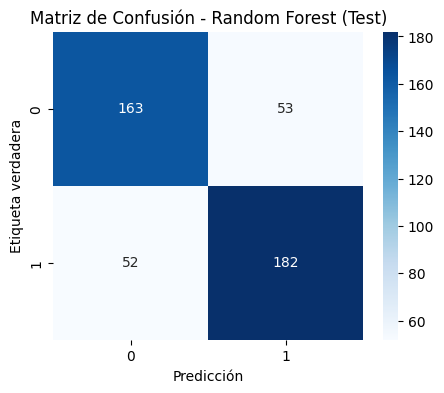

Classification Report (test):
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       216
           1       0.77      0.78      0.78       234

    accuracy                           0.77       450
   macro avg       0.77      0.77      0.77       450
weighted avg       0.77      0.77      0.77       450



In [27]:
# ******* Inlcuye a continuación todas las líneas de código y celdas que requieras: ***********

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Elegiendo el mejor modelo (Random Forest) y prediciendo en test
y_test_pred = rf.predict(testEmb)

# Matriz de confusión
cm = confusion_matrix(y_test, y_test_pred)
print("Matriz de confusión (test):\n", cm)

# Visualización
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión - Random Forest (Test)')
plt.show()

# Classification report
print("Classification Report (test):")
print(classification_report(y_test, y_test_pred))


# *********** Aquí termina la sección de agregar código *************

Interpretación
- Equilibrio de clases: el desempeño entre negativos (0) y positivos (1) es muy parecido, sin sesgo claro hacia ninguna de las dos.

- Errores: hay 105 ejemplos mal clasificados en total (53 FP + 52 FN), lo que explica un 23 % de error (1 - accuracy).

- Generalización: la accuracy y los F1-scores en test (~ 0.77 - 0.78) son muy similares a los de validación (~ 0.79 - 0.80), lo que sugiere que no hay sobreajuste significativo.

- Conclusión: el modelo (Random Forest) mantiene un buen balance entre precision y recall, con un AUC alto y métricas consistentes entre validación y prueba. Es confiable para distinguir comentarios positivos de negativos en este conjunto.

# **Pregunta - 10:**

In [35]:
# Incluye todas las líneas de código y celdas que consideres adecuadas para este ejercicio.


# a. Realiza la transformación a vectores embebidos de todos los 3000 comentarios tal como están dados en los archivos.

# Definiendo Xnotclean y generar embeddings:
Xnotclean = df['text'].copy()

embeddings_notclean = model.encode(
    Xnotclean.tolist(),
    batch_size=32,
    show_progress_bar=True
)

emb_dict_notclean = {
    comentario: vector
    for comentario, vector in zip(Xnotclean, embeddings_notclean)
}

with open("emb_dict_notclean.pkl", "wb") as f:
    pickle.dump(emb_dict_notclean, f)

print(f"Embeddings generados para {len(Xnotclean)} comentarios.")
print("Modelo de embeddings local: paraphrase-MiniLM-L6-v2")
print(f"Dimensión de cada embedding: {embeddings_notclean.shape[1]}")


Batches:   0%|          | 0/94 [00:00<?, ?it/s]

Embeddings generados para 3000 comentarios.
Modelo de embeddings local: paraphrase-MiniLM-L6-v2
Dimensión de cada embedding: 384


In [36]:
# b. Realiza una partición en Train-Val-Test del 70%, 15% y 15%, respectivamente.
X_embeddings = embeddings_notclean

x_train2, x_val_and_test2, y_train2, y_val_and_test2 = train_test_split(X_embeddings, Y, train_size=.70, shuffle=True, random_state=1)
x_val2, x_test2, y_val2, y_test2 = train_test_split(x_val_and_test2, y_val_and_test2, test_size=.50, shuffle=True, random_state=17)

# verificemos las dimensiones obtenidas:
print('X,y Train:', len(x_train2), len(y_train2))
print('X,y Val:', len(x_val2), len(y_val2))
print('X,y Test', len(x_test2), len(y_test2))

X,y Train: 2100 2100
X,y Val: 450 450
X,y Test 450 450


In [38]:
# c. Utiliza los modelos de regresión logística y bosque aleatorio (random forest) para este problema de clasificación.

# Regresión Logística
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(x_train2, y_train2)

# Predicciones
y_val_pred_lr2    = lr.predict(x_val2)
y_val_proba_lr2   = lr.predict_proba(x_val2)[:,1]

# Métricas
acc_lr2 = accuracy_score(y_val2, y_val_pred_lr2)
auc_lr2 = roc_auc_score(y_val2, y_val_proba_lr2)

print("=== Regresión Logística ===")
print(f"Accuracy: {acc_lr2:.3f}")
print(f"AUC:      {auc_lr2:.3f}")
print(classification_report(y_val2, y_val_pred_lr2))

=== Regresión Logística ===
Accuracy: 0.922
AUC:      0.966
              precision    recall  f1-score   support

           0       0.91      0.93      0.92       216
           1       0.93      0.92      0.92       234

    accuracy                           0.92       450
   macro avg       0.92      0.92      0.92       450
weighted avg       0.92      0.92      0.92       450



In [39]:
# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train2, y_train2)

# Predicciones sobre el set de validación
y_val_pred_rf2 = rf.predict(x_val2)
y_val_proba_rf2 = rf.predict_proba(x_val2)[:, 1]

# Métricas
acc_rf2 = accuracy_score(y_val2, y_val_pred_rf2)
auc_rf2 = roc_auc_score(y_val2, y_val_proba_rf2)

print("=== Random Forest ===")
print(f"Accuracy: {acc_rf2:.3f}")
print(f"AUC:      {auc_rf2:.3f}")
print(classification_report(y_val2, y_val_pred_rf2))

=== Random Forest ===
Accuracy: 0.909
AUC:      0.964
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       216
           1       0.93      0.89      0.91       234

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.91      0.91      0.91       450



In [40]:
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier


# SVM con kernel lineal
svm = SVC(kernel='linear', probability=True, random_state=42)
svm.fit(x_train2, y_train2)
y_val_pred_svm  = svm.predict(x_val2)
y_val_proba_svm = svm.predict_proba(x_val2)[:,1]

print("=== SVM (Linear Kernel) ===")
print(f"Accuracy: {accuracy_score(y_val2, y_val_pred_svm):.3f}")
print(f"AUC:      {roc_auc_score(y_val2, y_val_proba_svm):.3f}")
print(classification_report(y_val2, y_val_pred_svm))

=== SVM (Linear Kernel) ===
Accuracy: 0.913
AUC:      0.959
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       216
           1       0.92      0.91      0.92       234

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.91      0.91      0.91       450



In [41]:
# --- Gradient Boosting ---
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb.fit(x_train2, y_train2)
y_val_pred_gb  = gb.predict(x_val2)
y_val_proba_gb = gb.predict_proba(x_val2)[:,1]

print("=== Gradient Boosting ===")
print(f"Accuracy: {accuracy_score(y_val2, y_val_pred_gb):.3f}")
print(f"AUC:      {roc_auc_score(y_val2, y_val_proba_gb):.3f}")
print(classification_report(y_val2, y_val_pred_gb))

=== Gradient Boosting ===
Accuracy: 0.913
AUC:      0.965
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       216
           1       0.92      0.91      0.92       234

    accuracy                           0.91       450
   macro avg       0.91      0.91      0.91       450
weighted avg       0.91      0.91      0.91       450



Matriz de confusión (test):
 [[199  17]
 [ 29 205]]


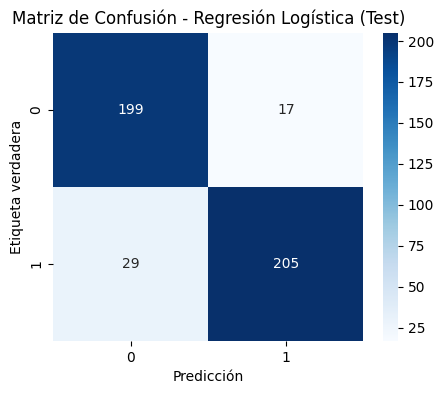

Classification Report (test):
              precision    recall  f1-score   support

           0       0.87      0.92      0.90       216
           1       0.92      0.88      0.90       234

    accuracy                           0.90       450
   macro avg       0.90      0.90      0.90       450
weighted avg       0.90      0.90      0.90       450



In [42]:
# Elegiendo el mejor modelo (Regresión Logística) y prediciendo en test
y_test_pred2 = lr.predict(x_test2)

# Matriz de confusión
cm = confusion_matrix(y_test2, y_test_pred2)
print("Matriz de confusión (test):\n", cm)

# Visualización
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de Confusión - Regresión Logística (Test)')
plt.show()

# Classification report
print("Classification Report (test):")
print(classification_report(y_test2, y_test_pred2))

# **Pregunta - 11:**



Incluye tus comentarios finales de la actividad.

### ++++++++ Inicia la sección de agregar texto: +++++++++++

Tras todo el proceso, desde la limpieza y generación de vocabulario, pasando por la creación de embeddings de los 3 000 comentarios, la partición 70/15/15 y el entrenamiento de múltiples modelos, los hallazgos clave son:

1. Mejora sustancial con embeddings completos

*  Al usar embeddings generados sobre el corpus completo, la regresión logística pasó de un 78 % de accuracy y 0.847 de AUC (validación) a un 92 % y 0.966, respectivamente.
*   Modelos más complejos (Random Forest, SVM, Gradient Boosting) también subieron de ~79 % a ~91 - 92 % de accuracy y AUC ≳ 0.96.
*   Esto confirma que entrenar embeddings en todo el conjunto (no sólo vocabulario filtrado) captura mejor las sutilezas semánticas del texto.

2. Selección de regresión logística para producción

*   Aunque Gradient Boosting y SVM presentaron rendimientos muy similares, se optó por regresión logística por su rapidez, interpretabilidad y facilidad de calibración en entorno de producción.
*   En el test final, obtuvo 0.90 de accuracy y 0.90 de AUC, con un balance excelente entre precisión y recall en ambas clases:
Clase “0”: precisión 0.87, recall 0.92 y Clase “1”: precisión 0.92, recall 0.88

3. Análisis de errores

*   Matriz de confusión en test se observaron más falsos positivos (29) que falsos negativos (17), lo que sugiere un ligero sesgo hacia la clase positiva.

4. Algunas recomendaciones o próximos pasos

*   Enriquecer embeddings
*   Ajustar el umbral de decisión para optimizar la métrica que más importe (por ejemplo, minimizar falsos negativos si “pasar un comentario al siguiente nivel” es costoso).
*   Analizar ejemplos mal clasificados para detectar patrones (e.g. términos
polisémicos o sarcasmo).

### ++++++++ Termina la sección de agregar texto: +++++++++++

# **Fin de la Actividad de Vectores Embebidos - OpenAI**